In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel("../data/data_feature_engineered.xlsx")

In [3]:
df.head()

,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,Grade_change,Income_change,Quaterly_rating_change,target,join_year,join_month
0,28,0,23,2,57387.0,1,1,571860.0,2,1,1,1,1,2018,12
1,31,0,7,2,67016.0,2,2,0.0,1,1,1,1,0,2020,11
2,43,0,13,2,65603.0,2,2,70000.0,1,1,1,1,1,2019,12
3,29,0,9,0,46368.0,1,1,40120.0,1,1,1,1,1,2019,1
4,31,1,11,1,78728.0,3,3,253000.0,2,1,1,2,0,2020,7


In [4]:
x = df.drop("target", axis=1)
y = df["target"]

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 7)

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
scaler = StandardScaler()
x_train_scaled = pd.DataFrame( scaler.fit_transform(x_train), columns= x_train.columns)
x_test_scaled = pd.DataFrame( scaler.transform(x_test), columns= x_test.columns)

In [10]:
import pickle
pickle.dump(scaler, open('../models/scaler.pkl', 'wb'))

## Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression

In [19]:
model_lr = LogisticRegression()
model_lr_cw = LogisticRegression(class_weight="balanced")

In [20]:
model_lr.fit(x_train_scaled, y_train)
model_lr_cw.fit(x_train_scaled, y_train)

LogisticRegression(class_weight='balanced')

In [22]:
print(model_lr.score(x_test_scaled, y_test))
print(model_lr_cw.score(x_test_scaled, y_test))

0.8364779874213837
0.8385744234800838


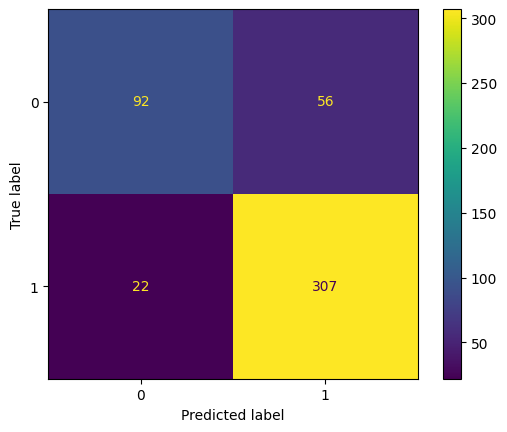

In [17]:
# code for confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = model_lr.predict(x_test_scaled)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

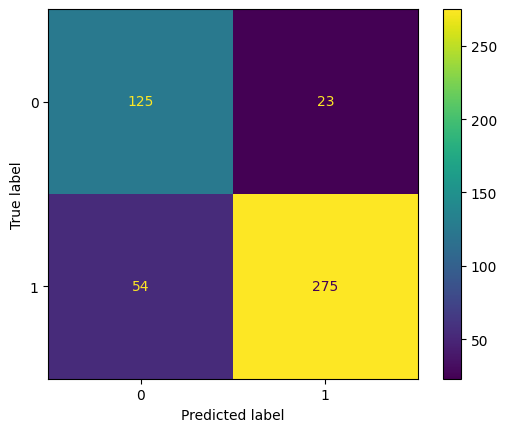

In [23]:
y_pred = model_lr_cw.predict(x_test_scaled)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

## Decision Tree Classifier

In [18]:
from sklearn.tree import DecisionTreeClassifier

In [24]:
from sklearn.model_selection import GridSearchCV

In [25]:
params = {"criterion":["gini", "entropy"],"max_depth":[i for i in range(3,30,3)],"min_samples_split":[i for i in range(2,10)]}

In [26]:
grid = GridSearchCV( estimator= DecisionTreeClassifier(),
                    param_grid = params,
                    scoring = 'accuracy',
                    cv = 5,
                    n_jobs=-1)

In [27]:
grid.fit(x_train_scaled,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 6, 9, 12, 15, 18, 21, 24, 27],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='accuracy')

In [28]:
print("Best params: ", grid.best_params_)
print("Best score: ", grid.best_score_)

Best params:  {'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 5}
Best score:  0.8702652300041442


In [32]:
model_dt = DecisionTreeClassifier(**grid.best_params_)
model_dt.fit(x_train_scaled, y_train)


DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_split=5)

In [29]:
from sklearn.metrics import accuracy_score

In [35]:
y_pred = model_dt.predict(x_test_scaled)
accuracy_score(y_test, y_pred)

0.89937106918239

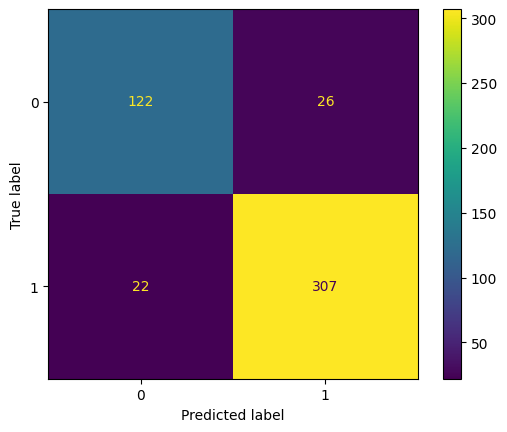

In [36]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

## Random Forests

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
params = { "n_estimators": [100,200,300,500], "max_depth":[2,3,4,5,7],"bootstrap":[True, False],"criterion" :["gini", "entropy"]}

In [39]:
grid = GridSearchCV(estimator = RandomForestClassifier(),
                    param_grid=params,
                    scoring="accuracy",
                    cv = 5,
                    n_jobs=-1
                    )

In [40]:
grid.fit(x_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 7],
                         'n_estimators': [100, 200, 300, 500]},
             scoring='accuracy')

In [41]:
print("Best params: ", grid.best_params_)
print("Best score: ", grid.best_score_)

Best params:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': 7, 'n_estimators': 200}
Best score:  0.8881185246581019


In [42]:
model_rf = RandomForestClassifier(**grid.best_params_, class_weight="balanced")

In [43]:
model_rf.fit(x_train_scaled, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=7,
                       n_estimators=200)

In [44]:
y_pred = model_rf.predict(x_test_scaled)
accuracy_score(y_test, y_pred)

0.9014675052410901

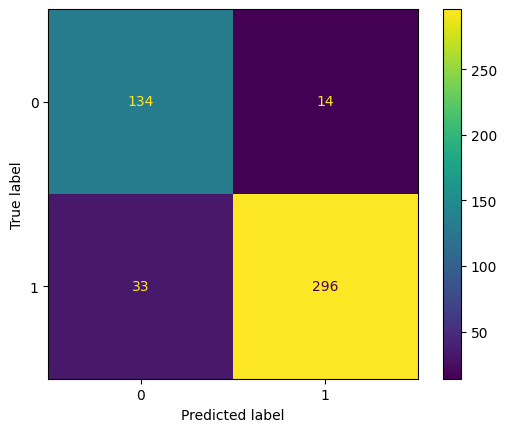

In [45]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

## GBDT

In [46]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

In [51]:
params = {
    "n_estimators": [50,100,150,200,300],
    "max_depth" : [2, 3, 4, 5, 7],
    "max_leaf_nodes" : [20, 40, 80],
}

In [52]:
grid = RandomizedSearchCV(estimator = GradientBoostingClassifier(), param_distributions =params, scoring = "accuracy", cv=3, n_jobs = -1, verbose = 1)

In [53]:
grid.fit(x_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [2, 3, 4, 5, 7],
                                        'max_leaf_nodes': [20, 40, 80],
                                        'n_estimators': [50, 100, 150, 200,
                                                         300]},
                   scoring='accuracy', verbose=1)

In [54]:
grid.best_params_, grid.best_score_

({'n_estimators': 50, 'max_leaf_nodes': 40, 'max_depth': 3},
 np.float64(0.8902257880225539))

In [55]:
model_gbdt = grid.best_estimator_

In [56]:
model_gbdt.fit(x_train_scaled, y_train)

GradientBoostingClassifier(max_leaf_nodes=40, n_estimators=50)

In [59]:
# model_gbdt.score(x_test_scaled, y_test)

In [61]:
y_pred = model_gbdt.predict(x_test_scaled)
accuracy_score(y_test, y_pred)

0.9014675052410901

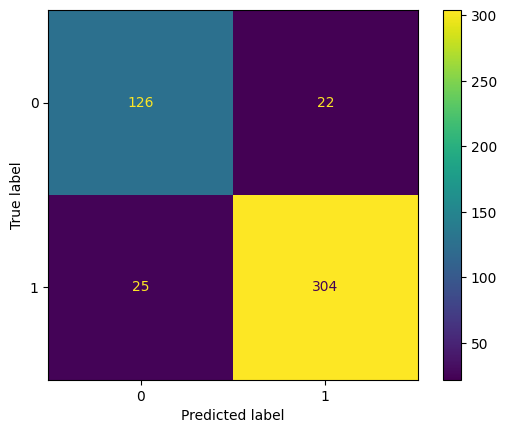

In [62]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

In [64]:
import lightgbm as lgb

In [65]:
gridParams = {
    'learning_rate': [0.1, 0.3, 0.5],
    'boosting_type' : ['gbdt'],
    'max_depth' : [5,6,7,8],
    'colsample_bytree' : [0.5,0.7],
    'subsample' : [0.5,0.7],
    }

clf = lgb.LGBMClassifier()
grid = RandomizedSearchCV(clf,gridParams,verbose=3,scoring='accuracy',cv=3,n_jobs = -1,n_iter=10)

In [66]:
grid.fit(x_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1287, number of negative: 617
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 630
[LightGBM] [Info] Number of data points in the train set: 1904, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.675945 -> initscore=0.735200
[LightGBM] [Info] Start training from score 0.735200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(), n_jobs=-1,
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.5, 0.7],
                                        'learning_rate': [0.1, 0.3, 0.5],
                                        'max_depth': [5, 6, 7, 8],
                                        'subsample': [0.5, 0.7]},
                   scoring='accuracy', verbose=3)

In [67]:
grid.best_params_, grid.best_score_

({'subsample': 0.7,
  'max_depth': 6,
  'learning_rate': 0.1,
  'colsample_bytree': 0.5,
  'boosting_type': 'gbdt'},
 np.float64(0.8828742227410848))

In [68]:
model_lgbm = grid.best_estimator_

In [69]:
model_lgbm.fit(x_train_scaled, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1287, number of negative: 617
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 630
[LightGBM] [Info] Number of data points in the train set: 1904, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.675945 -> initscore=0.735200
[LightGBM] [Info] Start training from score 0.735200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

LGBMClassifier(colsample_bytree=0.5, max_depth=6, subsample=0.7)

In [70]:
model_lgbm.score(x_test_scaled, y_test)

0.8909853249475891

In [71]:
y_pred = model_lgbm.predict(x_test_scaled)
accuracy_score(y_test, y_pred)

0.8909853249475891

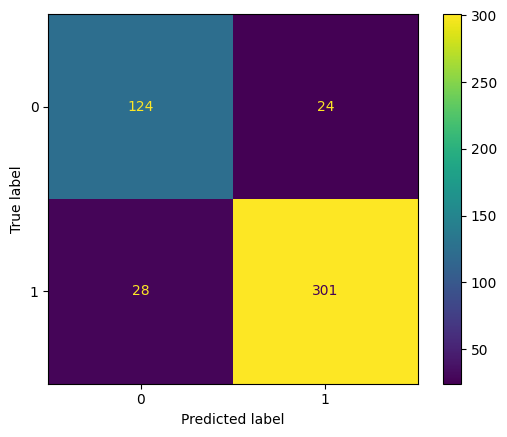

In [72]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

In [73]:
print("logistic regression", model_lr.score(x_test_scaled, y_test))
print("logistic regression with class weight", model_lr_cw.score(x_test_scaled, y_test))
print("decision tree", model_dt.score(x_test_scaled, y_test))
print("random forest", model_rf.score(x_test_scaled, y_test))
print("gradient boosting", model_gbdt.score(x_test_scaled, y_test))
print("lightgbm", model_lgbm.score(x_test_scaled, y_test))

logistic regression 0.8364779874213837
logistic regression with class weight 0.8385744234800838
decision tree 0.89937106918239
random forest 0.9014675052410901
gradient boosting 0.9014675052410901
lightgbm 0.8909853249475891


In [75]:
import pickle
pickle.dump(model_rf, open('../models/model_rf.pkl', 'wb'))
pickle.dump(model_lgbm, open('../models/model_lgbm.pkl', 'wb'))
